In [1]:
!pip install xgboost catboost lightgbm autogluon

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBRegressor
import pickle
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifierCV
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [3]:
data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

full = pd.concat([data, test_data], sort=False)
full.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

## Data analysis

In [4]:
data.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
data.value_counts('Survived')

,count
Survived,
0,549
1,342


### Выводы: пропуски в признаках Age и Cabin. Есть признаки данных с нечисловыми типом данных. Некоторый дисбланс классов в целевой переменной.

## Визуализация

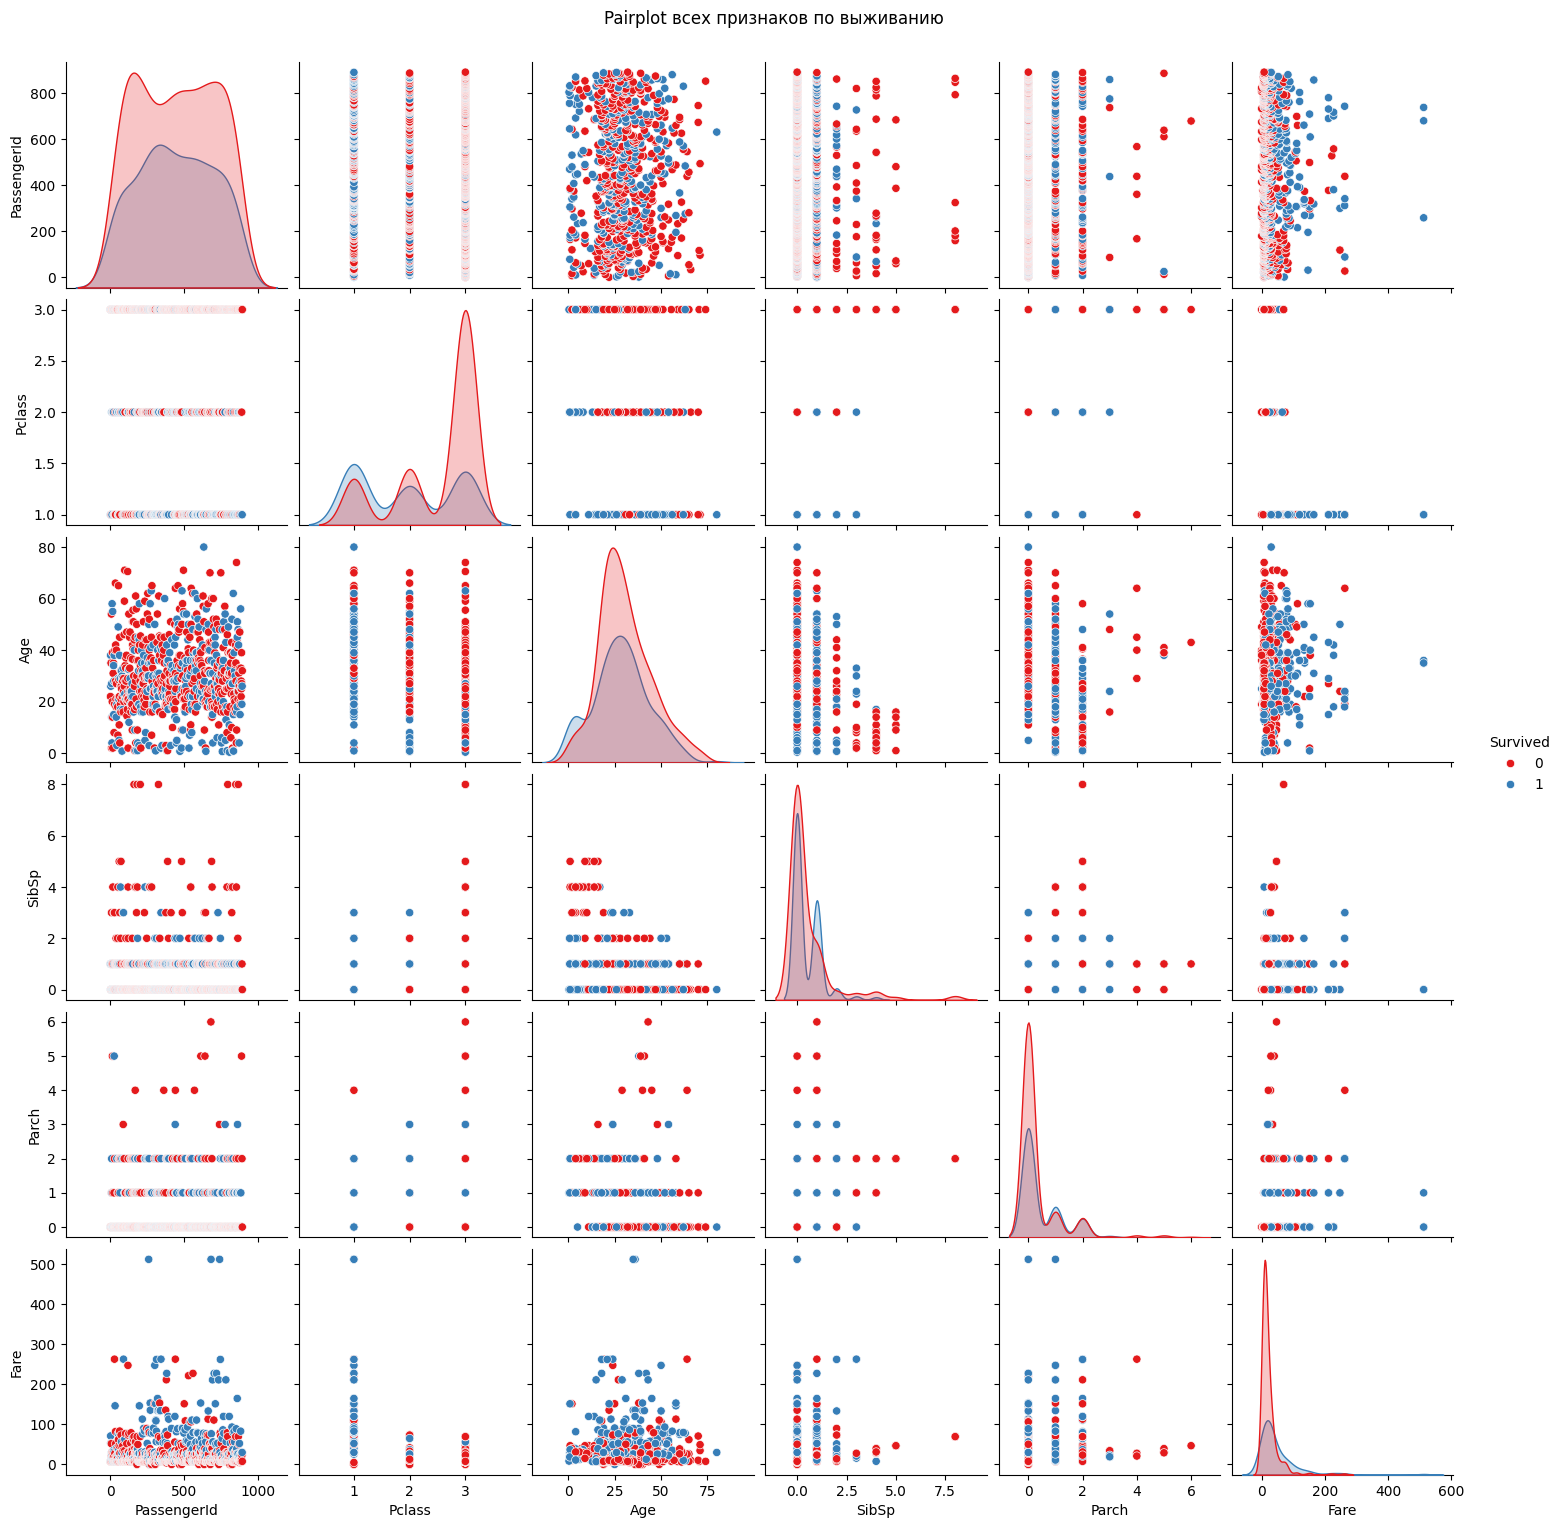

In [7]:
sns.pairplot(data=data, hue='Survived', palette='Set1')
plt.suptitle('Pairplot всех признаков по выживанию', y=1.02)
plt.show()

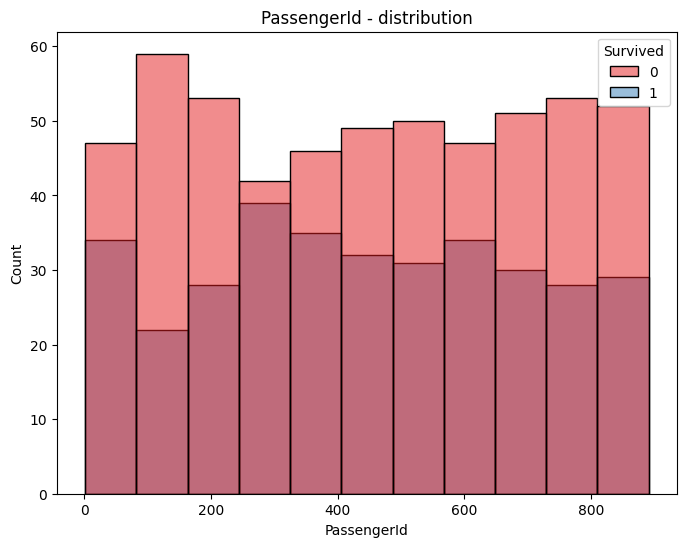

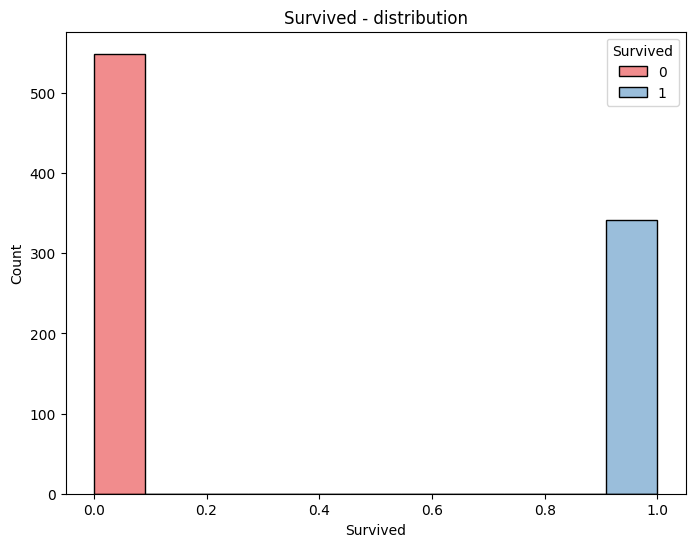

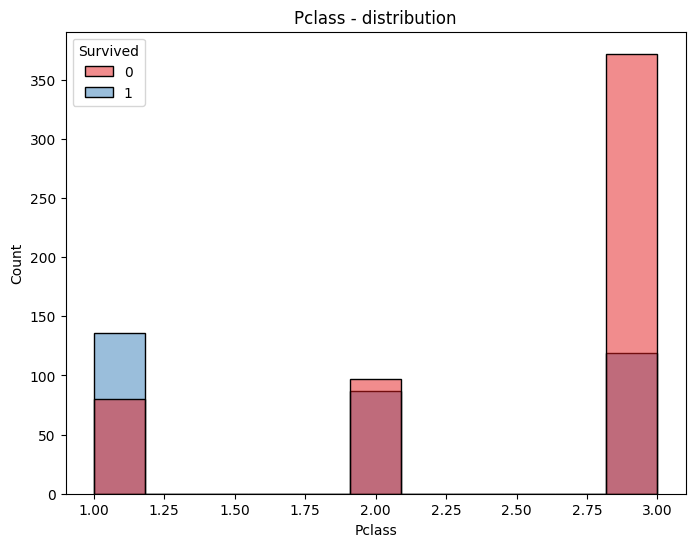

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


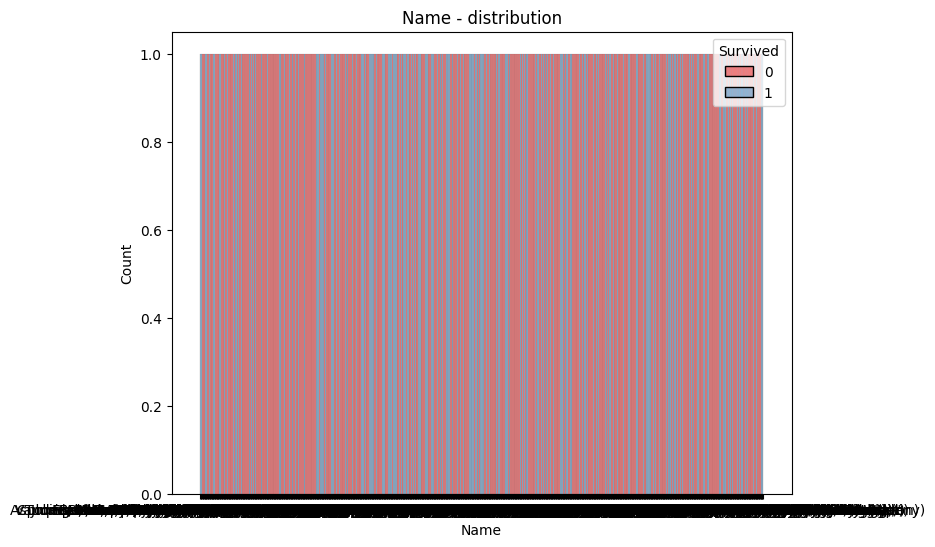

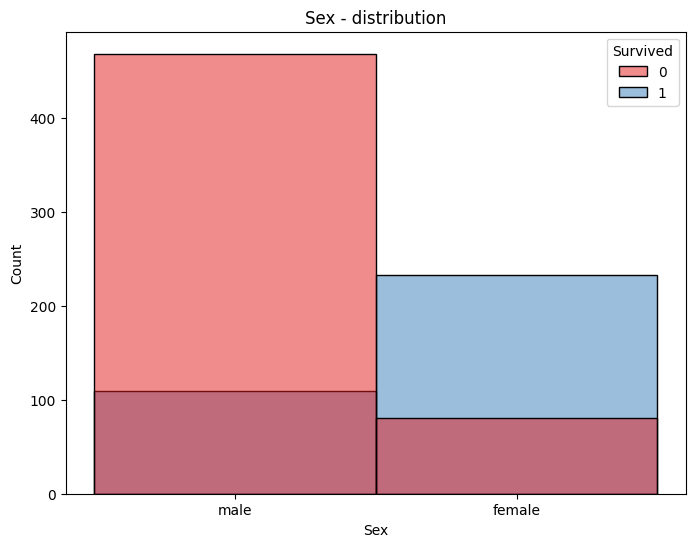

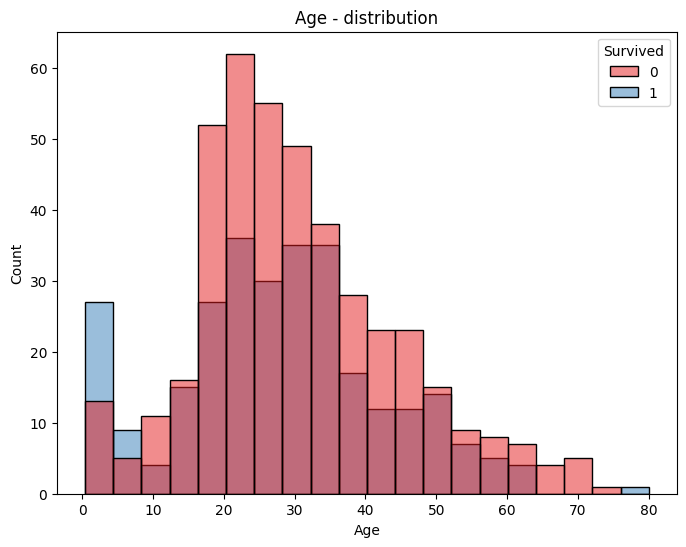

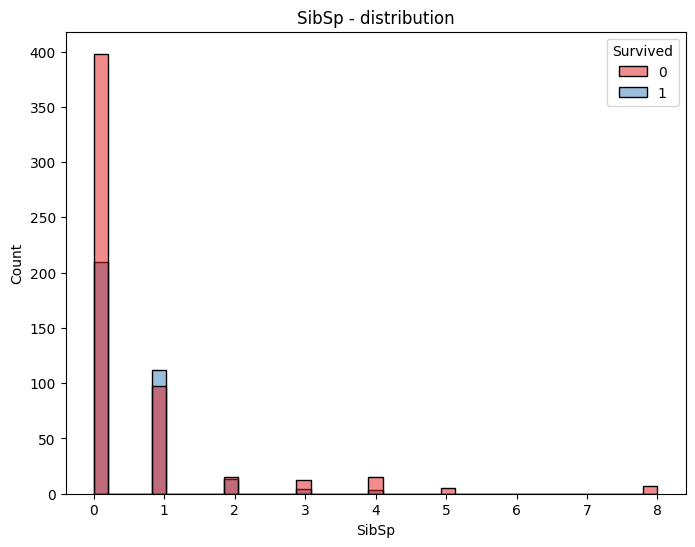

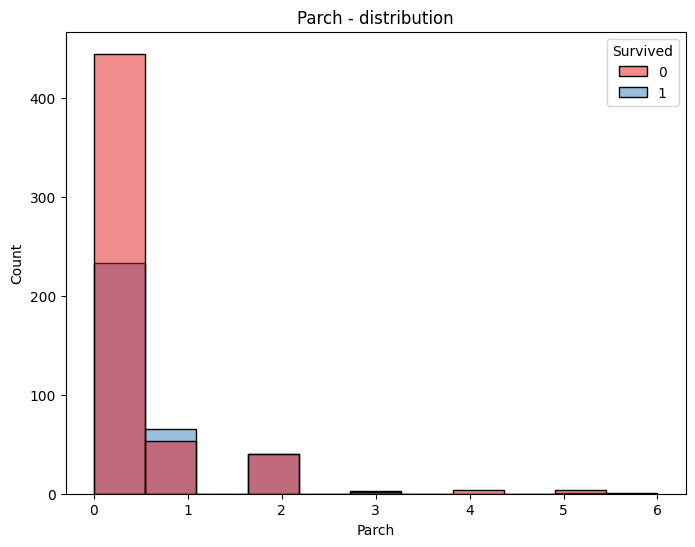

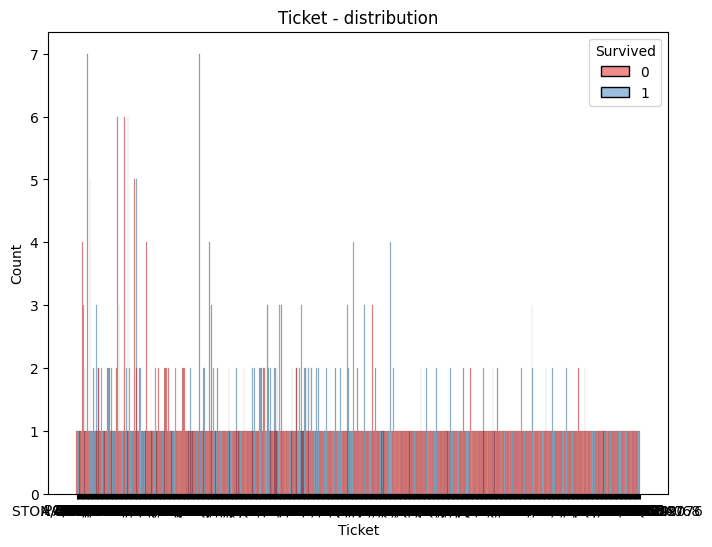

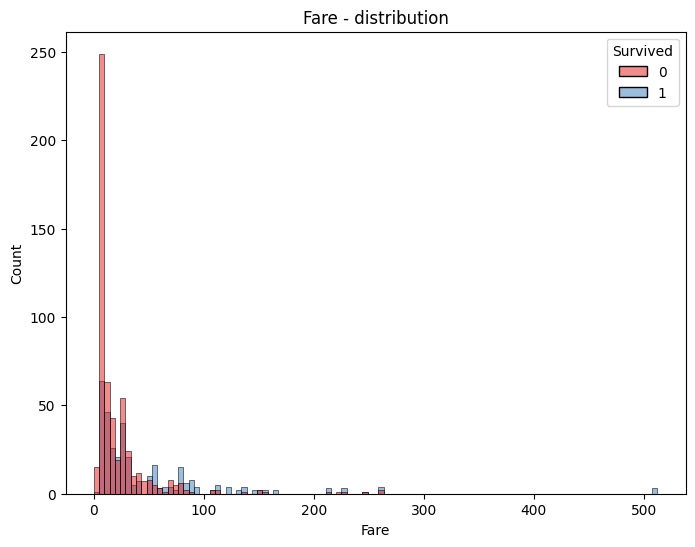

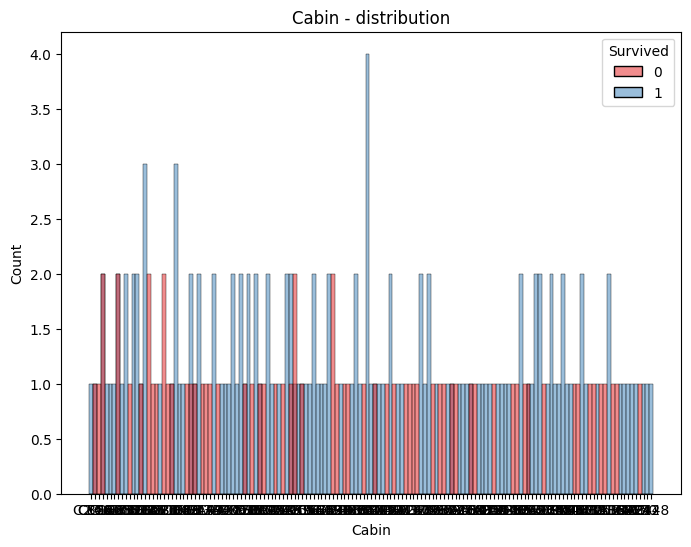

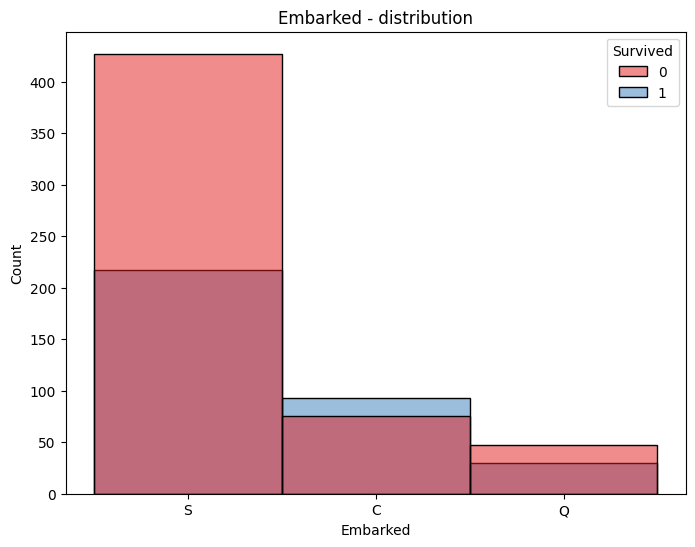

In [8]:
for i in data:
    plt.figure(figsize=(8,6))
    sns.histplot(data=data, x=i, hue='Survived', palette='Set1')
    plt.title(f'{i} - distribution')
    plt.show()

## Feature eng

### Новые фичи

In [9]:
# Title
full['Title'] = full['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
full['Title'] = full['Title'].replace(['Mlle', 'Ms'], 'Miss')
full['Title'] = full['Title'].replace(['Mme'], 'Mrs')
full['Title'] = full['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Col',
                                       'Sir', 'Capt', 'Countess', 'Jonkheer', 'Dona'], 'Rare')

# Family
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full['IsAlone'] = (full['FamilySize'] == 1).astype(int)

# Cabin
full['Deck'] = full['Cabin'].fillna('U').str[0]

# Ticket prefix
full['TicketPrefix'] = full['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'NUM')

full['FarePerPerson'] = full['Fare'] / full['FamilySize']




### Обработка нечисловых типов данных

In [10]:
full.select_dtypes(include=['object']).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Deck',
       'TicketPrefix'],
      dtype='object')

In [11]:
le = LabelEncoder()

full = full.drop(['Name', 'Ticket'], axis=1) # сложно получить информацию из этих данных
full['Sex'] = le.fit_transform(full['Sex'])
full = pd.get_dummies(full, columns=['Embarked'], prefix='Embarked')

In [12]:
cat_cols = ['Sex', 'Title', 'Deck', 'TicketPrefix']
full[cat_cols] = full[cat_cols].apply(LabelEncoder().fit_transform)

### Обработка пропусков

In [13]:
full.columns[full.isnull().any()]

Index(['Survived', 'Age', 'Fare', 'Cabin', 'FarePerPerson'], dtype='object')

In [14]:
full = full.drop('Cabin', axis=1) # слишком много пропусков

In [15]:
full['Age'] = full.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
full['Fare'] = full['Fare'].fillna(value=full.Fare.mode()[0])
full['FarePerPerson'] = full['FarePerPerson'].fillna(value=full.Fare.mode()[0])

In [16]:
full.isna().sum()

,0
PassengerId,0
Survived,418
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Title,0
FamilySize,0


# ML

## Сплит данных

In [245]:
full_train = full[full['Survived'].notna()].drop(['PassengerId'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(full_train.drop(['Survived'], axis=1), full_train['Survived'], test_size=0.2, random_state=47)
X_test_final = full[full['Survived'].isna()].drop(['PassengerId', 'Survived'], axis=1)

## XGboost

In [19]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],              # побольше деревьев для стабильности
    'max_depth': [3, 4, 5, 6, 7],                     # Titanic не требует глубоких деревьев
    'learning_rate': [0.001, 0.01, 0.05, 0.1],        # меньшая скорость → лучше качество
    'subsample': [0.6, 0.8, 1.0],                     # как dropout по строкам
    'colsample_bytree': [0.6, 0.8, 1.0],              # как dropout по признакам
    'min_child_weight': [1, 3, 5, 10],                # регуляризация — чем больше, тем жёстче
    'gamma': [0, 0.1, 0.3, 1],                        # минимальный gain для сплита
    'reg_alpha': [0, 0.01, 0.1, 1],                   # L1-регуляризация
    'reg_lambda': [0.5, 1, 1.5, 2],                   # L2-регуляризация
}

# F1 как метрика
scorer = make_scorer(f1_score, average='binary')

xg_tree = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# GridSearchCV
grid = RandomizedSearchCV(
    n_iter=100,
    estimator=xg_tree,
    param_distributions=param_distributions,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Обучение
grid.fit(X_train, y_train)

# Лучшие параметры
print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best F1 score: 0.7789844831463626


In [45]:
grid.best_estimator_.save_model('xgb_model.json')

## Random Forest

In [38]:
# Определяем модель
rf = RandomForestClassifier(random_state=42)

# Создаем параметрическую сетку
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(50, 400, 20)],  # Количество деревьев
    'max_depth': [int(x) for x in np.linspace(5, 100, 10)] + [None],  # Макс. глубина
    'min_samples_split': [2, 5, 10, 15, 20, 30],  # Минимальное число образцов для разделения
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],  # Минимальное число образцов в листе
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],  # Количество фичей для разбиения
    'criterion': ['gini', 'entropy', 'log_loss'],  # Критерий разделения
    'max_samples': [None, 0.5, 0.7, 0.9],  # % образцов для обучения каждого дерева
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Веса классов
    'ccp_alpha': [0.0, 0.01, 0.1, 1.0],  # Параметр обрезки
    'min_impurity_decrease': [0.0, 0.01, 0.1, 1.0],  # Минимальное уменьшение примеси
}

# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,  # Сколько комбинаций попробовать (можно увеличить)
    cv=5,  # Кросс-валидация (можно 3, 5, 10)
    scoring=scorer,  # Метрика (можно 'f1', 'roc_auc' и т.д.)
    n_jobs=-1,  # Использовать все ядра CPU
    verbose=2,  # Вывод лога
    random_state=42,
)

# Запускаем поиск
random_search.fit(X_train, y_train)

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
print("Лучший скор:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'n_estimators': 400, 'min_samples_split': 30, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'max_samples': 0.7, 'max_features': 0.5, 'max_depth': 47, 'criterion': 'log_loss', 'class_weight': 'balanced', 'ccp_alpha': 0.01}
Лучший скор: 0.7879285654259055


In [49]:
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

## Логистическая регрессия

In [81]:
log_reg = LogisticRegression()

param_dist_log = {
    'C': np.logspace(-3, 2, 6),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'max_iter': [50, 100, 200],
    'class_weight': [None, 'balanced'],
}

random_search_log = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist_log,
    n_iter=100,
    cv=5,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)

random_search_log.fit(X_train, y_train)
print("Лучшие параметры:", random_search_log.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Лучшие параметры: {'solver': 'newton-cg', 'max_iter': 100, 'class_weight': 'balanced', 'C': np.float64(1.0)}


In [82]:
random_search_log.best_score_

np.float64(0.7499397985481162)

In [84]:
with open('log_reg_model.pkl', 'wb') as f:
    pickle.dump(random_search_log.best_estimator_, f)

## DL

In [213]:
# Конвертация в тензоры (для CrossEntropyLoss нужны LongTensor для labels)
train_tensors = TensorDataset(
    torch.FloatTensor(X_train.values.astype('float32')),  # Особенности - float32
    torch.LongTensor(y_train.values.astype('int64')))      # Метки - int64 (long)
val_tensors = TensorDataset(
    torch.FloatTensor(X_test.values.astype('float32')),
    torch.LongTensor(y_test.values.astype('int64')))

# DataLoader
train_loader = DataLoader(train_tensors, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tensors, batch_size=32)

net = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(),
    nn.Dropout(0.4),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Dropout(0.2),

    nn.Linear(128, 2)
)

# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Обучение
epochs = 500
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Убрал .squeeze()
        loss.backward()
        optimizer.step()

    # Валидация
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    scheduler.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}: Loss = {loss.item():.4f}, Val Loss = {val_loss/len(val_loader):.4f}, Val Acc = {100*correct/total:.2f}%')

Epoch 50: Loss = 0.7019, Val Loss = 0.6064, Val Acc = 66.48%
Epoch 100: Loss = 0.5366, Val Loss = 0.5830, Val Acc = 69.83%
Epoch 150: Loss = 0.4839, Val Loss = 0.5539, Val Acc = 74.30%
Epoch 200: Loss = 0.5021, Val Loss = 0.5344, Val Acc = 77.65%
Epoch 250: Loss = 0.3837, Val Loss = 0.5144, Val Acc = 78.21%
Epoch 300: Loss = 0.2180, Val Loss = 0.5143, Val Acc = 78.21%
Epoch 350: Loss = 0.4326, Val Loss = 0.5112, Val Acc = 77.65%
Epoch 400: Loss = 0.5095, Val Loss = 0.4929, Val Acc = 79.33%
Epoch 450: Loss = 0.1272, Val Loss = 0.4900, Val Acc = 78.77%
Epoch 500: Loss = 0.3621, Val Loss = 0.4823, Val Acc = 78.21%


In [196]:
class TrainedPytorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, device='auto'):
        self.model = model
        self.device = device

    def fit(self, X, y=None):
        # Пустой метод, т.к. модель уже обучена
        return self

    def predict_proba(self, X):
        if self.device == 'auto':
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            device = torch.device(self.device)

        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X.values.astype('float32'))
            outputs = self.model(X_tensor)
            return torch.softmax(outputs, dim=1).cpu().numpy()

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def __sklearn_is_fitted__(self):
        """Метод для проверки 'обученности' модели"""
        return True  # Всегда возвращает True, т.к. модель предобучена

## Стейкинг

### Свое решение

In [214]:
xgb = grid.best_estimator_
rf = random_search.best_estimator_
lgr = random_search_log.best_estimator_

xgb_pipeline = make_pipeline(xgb)
rf_pipeline = make_pipeline(rf)
logreg_pipeline = make_pipeline(lgr)
pytorch_wrapper = TrainedPytorchWrapper(model)


# 3. Создаем Stacking с "замороженными" моделями
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_pipeline),
        ('rf', rf_pipeline),
        ('logreg', logreg_pipeline),
        ('nn', pytorch_wrapper)
    ],
    final_estimator=LogisticRegression(),  # Мета-модель (обучится с нуля)
    cv='prefit',  # Критически важно! Говорит использовать предобученные модели
    n_jobs=-1
)

# 4. Обучение только мета-модели (базовые модели не трогаются!)
stacking_model.fit(X_train, y_train)
stacking_model.score(X_train, y_train), stacking_model.score(X_test, y_test),

(0.9185393258426966, 0.8268156424581006)

### Готовое решение

In [246]:
from autogluon.tabular import TabularPredictor

predictor = TabularPredictor(label='Survived', eval_metric='roc_auc')
predictor.fit(train_data=full_train, time_limit=3600)  # можно задать timeout

No path specified. Models will be saved in: "AutogluonModels/ag-20250606_021632"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       10.05 GB / 12.67 GB (79.3%)
Disk Space Avail:   65.15 GB / 107.72 GB (60.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competition

## Итоги

## Создание самбишн

In [254]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score


nn_preds = pytorch_wrapper.predict(X_test)
xgb_preds = xgb.predict(X_test)
rf_preds = rf.predict(X_test)
log_preds = lgr.predict(X_test)

# StackingClassifier (ручной)
stack_preds = stacking_model.predict(X_test)

# AutoGluon
autogluon_preds = predictor.predict(X_test)

# ======== Метрики =========
results = []

def add_result(name, y_true, y_pred):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_pred)
    })

add_result("PyTorch NN", y_test, nn_preds)
add_result("XGBoost", y_test, xgb_preds)
add_result("Random Forest", y_test, rf_preds)
add_result("Logistic Regression", y_test, log_preds)
add_result("Manual Stacking", y_test, stack_preds)
add_result("AutoGluon Ensemble", y_test, autogluon_preds)

# ======== Таблица =========
results_df = pd.DataFrame(results).sort_values('ROC AUC', ascending=False)
results_df.to_csv('results.csv')
results_df

,Model,Accuracy,F1-score,ROC AUC
5,AutoGluon Ensemble,0.916201,0.888889,0.905636
1,XGBoost,0.826816,0.770370,0.811796
4,Manual Stacking,0.826816,0.770370,0.811796
2,Random Forest,0.793296,0.751678,0.794495
3,Logistic Regression,0.765363,0.716216,0.763893
0,PyTorch NN,0.782123,0.706767,0.762320


In [62]:
submissions = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictor.predict(X_test_final).astype(int)  # XGBoost может вернуть float
})
submissions.to_csv('submission.csv', index=False)